In [12]:
from pathlib import Path
import json
from pprint import pprint

In [5]:
dataset_path = Path('/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024')

In [7]:
for path in (dataset_path / 'ClashRoyale').glob('*'):
    print(path)

/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/1674730914_1e:65:95:7e:34:0b_com.supercell.clashroyale_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json
/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/1674728356_1e:65:95:7e:34:0b_com.google.android.gms.persistent_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json
/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/1674213606_1e:65:95:7e:34:0b_com.google.android.gms.persistent_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json
/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/1674729903_1e:65:95:7e:34:0b_com.supercell.clashroyale_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json
/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/1674728883_1e:65:95:7e:34:0b_com.supercell.clashroyale_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json
/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/

In [8]:
example_json_path = Path('/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/ClashRoyale/1674730914_1e:65:95:7e:34:0b_com.supercell.clashroyale_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json')

In [11]:
with open(example_json_path, 'r') as f:
    example_json = json.load(f)

In [18]:
len(str(example_json))

7519324

In [21]:
import os

def tree(path, prefix="", max_files=5):
    """Print directory tree like Linux 'tree', but limit files per dir."""
    entries = sorted(os.listdir(path))
    total = len(entries)
    shown = entries[:max_files]

    for i, name in enumerate(shown):
        fullpath = os.path.join(path, name)
        connector = "└── " if (i == len(shown) - 1 and total <= max_files) else "├── "
        print(prefix + connector + name)

        if os.path.isdir(fullpath):
            extension = "    " if (i == len(shown) - 1 and total <= max_files) else "│   "
            tree(fullpath, prefix + extension, max_files)

    # If there are more files, show ellipsis
    if total > max_files:
        print(prefix + "└── ...")

# Example:
tree("/home/anatbr/dataset/mirage")

├── MIRAGE-2019_traffic_dataset_downloadable
│   ├── Mi5_38_a4_ed_18_cc_bf
│   │   ├── 1494596297_air.com.hypah.io.slither_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│   │   ├── 1494596682_air.com.hypah.io.slither_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│   │   ├── 1494597081_air.com.hypah.io.slither_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│   │   ├── 1494597474_air.com.hypah.io.slither_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│   │   ├── 1494597839_air.com.hypah.io.slither_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│   │   └── ...
│   └── Nexus7_bc_ee_7b_a4_09_47
│       ├── 1494419517_com.twitter.android_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│       ├── 1494419966_com.twitter.android_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│       ├── 1494420477_com.twitter.android_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│       ├── 1494421382_com.twitter.android_MIRAGE-2019_traffic_dataset_labeled_biflows.json
│       ├── 1494434240_

In [1]:
import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint

In [6]:
def find_all_json(root):
    print(f"🔍 Scanning directory: {root}\n")
    paths = []

    for dirpath, _, files in os.walk(root):
        for f in files:
            if f.endswith(".json"):
                paths.append(os.path.join(dirpath, f))

    paths = sorted(paths)
    print(f"📄 Found {len(paths)} JSON files.\n")
    return paths


In [7]:
def extract_bf_features(bf):
    """
    Flatten flow_features into a 1D vector.

    Expected structure (simplified):

      bf = {
        "flow_features": {
          "iat": {
            "biflow": {...},
            "upstream_flow": {...},
            "downstream_flow": {...}
          },
          "packet_length": {
            "biflow": {...},
            "upstream_flow": {...},
            "downstream_flow": {...}
          }
        },
        "flow_metadata": {...},
        "packet_data": {...}
      }
    """
    ff = bf.get("flow_features", {})
    if not ff:
        return None, None

    feature_names = []
    values = []

    # We combine both iat + packet_length, and all scopes
    for feat_name in ["iat", "packet_length"]:
        feat_group = ff.get(feat_name, {})
        if not isinstance(feat_group, dict):
            continue

        for scope in ["biflow", "upstream_flow", "downstream_flow"]:
            scope_dict = feat_group.get(scope, {})
            if not isinstance(scope_dict, dict):
                continue

            for stat_name in sorted(scope_dict.keys()):
                key = f"{feat_name}_{scope}_{stat_name}"
                val = scope_dict[stat_name]

                # robust cast to float; treat None as np.nan
                if val is None:
                    val_f = np.nan
                else:
                    try:
                        val_f = float(val)
                    except Exception:
                        val_f = np.nan

                feature_names.append(key)
                values.append(val_f)

    if not values:
        return None, None

    return np.array(values, dtype=np.float32), feature_names


In [8]:
def compute_label_stats_single_pass(
    json_paths,
    stat_label_key="BF_sublabel",   # label in flow_metadata used for grouping
    max_files_per_app=2,            # how many JSONs to use per app (folder)
):
    """
    Single pass over json_paths:
      - Each JSON is opened at most once.
      - For each *app* (folder name), use at most `max_files_per_app` JSON files.
      - For biflows in those files, compute mean/std of flattened flow_features
        grouped by `stat_label_key` from flow_metadata.

    Returns
    -------
    label_stats : dict
        label -> {"count": int, "mean": np.array, "std": np.array}
    feature_names : list[str]
        names of features in the vector
    app_to_files : dict
        app_name -> list of JSON paths actually used
    """

    # per-app file limit
    app_file_count = defaultdict(int)
    app_to_files = defaultdict(list)

    # stats per label
    stats_count = defaultdict(int)
    stats_sum = {}
    stats_sum_sq = {}
    feature_names = None

    print(f"📊 Starting single-pass processing over {len(json_paths)} JSON files…\n")

    for path in tqdm(json_paths, desc="Processing JSON files"):
        # app name from directory: .../MIRAGE-AppAct-2024/Discord/file.json
        app_name = os.path.basename(os.path.dirname(path))

        # respect max_files_per_app
        if app_file_count[app_name] >= max_files_per_app:
            continue

        try:
            with open(path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[WARN] Cannot open {path}: {e}")
            continue

        if not isinstance(data, dict) or not data:
            continue

        # we *are* going to use this file for this app
        app_file_count[app_name] += 1
        app_to_files[app_name].append(path)

        # top-level: keys are biflow IDs, values are biflow dicts
        for bf_id, bf in data.items():
            if not isinstance(bf, dict):
                continue

            meta = bf.get("flow_metadata", {})
            label = meta.get(stat_label_key)
            if label is None:
                continue

            vec, fname = extract_bf_features(bf)
            if vec is None:
                continue

            # initialize feature_names once
            if feature_names is None:
                feature_names = fname
            else:
                # if feature_names already set, make sure size matches
                if len(vec) != len(feature_names):
                    # you can choose to handle this differently; for now: skip
                    # print(f"[WARN] Feature length mismatch in {path}, bf_id={bf_id}")
                    continue

            if label not in stats_sum:
                stats_sum[label] = np.zeros_like(vec, dtype=np.float64)
                stats_sum_sq[label] = np.zeros_like(vec, dtype=np.float64)

            # handle NaNs by treating them as zeros in accumulators,
            # but not changing count (simplest approach for EDA)
            vec_clean = np.nan_to_num(vec.astype(np.float64), nan=0.0)

            stats_count[label] += 1
            stats_sum[label] += vec_clean
            stats_sum_sq[label] += vec_clean ** 2

    # build final stats
    label_stats = {}
    for label, count in stats_count.items():
        if count == 0:
            continue

        s = stats_sum[label]
        s2 = stats_sum_sq[label]
        mean = s / count
        var = s2 / count - mean**2
        var = np.maximum(var, 0.0)
        std = np.sqrt(var)

        label_stats[label] = {
            "count": count,
            "mean": mean.astype(np.float32),
            "std": std.astype(np.float32),
        }

    print("\n✅ Finished single-pass stats computation.")
    print("📌 Files actually used per app:")
    for app, files in app_to_files.items():
        print(f"  • {app}: {len(files)} files")

    return label_stats, feature_names, app_to_files


In [9]:
root = "/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024"

json_paths = find_all_json(root)

label_stats, feature_names, app_to_files = compute_label_stats_single_pass(
    json_paths,
    stat_label_key="BF_sublabel",  # change to "BF_label" / other if you want
    max_files_per_app=2,
)


🔍 Scanning directory: /home/anatbr/dataset/mirage/MIRAGE-AppAct-2024

📄 Found 2245 JSON files.

📊 Starting single-pass processing over 2245 JSON files…



Processing JSON files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2245/2245 [01:13<00:00, 30.45it/s]


✅ Finished single-pass stats computation.
📌 Files actually used per app:
  • ClashRoyale: 2 files
  • Crunchyroll: 2 files
  • Discord: 2 files
  • GotoMeeting: 2 files
  • JitsiMeet: 2 files
  • KakaoTalk: 2 files
  • Line: 2 files
  • Meet: 2 files
  • Messenger: 2 files
  • Omlet: 2 files
  • Signal: 2 files
  • Skype: 2 files
  • Slack: 2 files
  • Teams: 2 files
  • Telegram: 2 files
  • Trueconf: 2 files
  • Twitch: 2 files
  • Webex: 2 files
  • WhatsApp: 2 files
  • Zoom: 2 files


In [10]:
dfs = {}

print("\n📈 Per-label feature statistics (flow_features):\n")

for label, s in label_stats.items():
    df = pd.DataFrame({
        "feature": feature_names,
        "mean": s["mean"],
        "std": s["std"],
    })
    dfs[label] = df

    print(f"=== {label} — {s['count']} biflows ===")
    display(df.head(10))
    print()



📈 Per-label feature statistics (flow_features):

=== /system/bin/netd — 482 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000937,0.000657
1,iat_biflow_20_percentile,0.001676,0.001314
2,iat_biflow_30_percentile,0.003545,0.002737
3,iat_biflow_40_percentile,0.006952,0.004090
4,iat_biflow_50_percentile,0.010959,0.004105
5,iat_biflow_60_percentile,0.014508,0.003360
6,iat_biflow_70_percentile,0.019404,0.016634
7,iat_biflow_80_percentile,0.134958,0.573702
8,iat_biflow_90_percentile,1.626909,1.913804
9,iat_biflow_kurtosis,15.253835,5.755916



=== com.supercell.clashroyale — 29 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.020927,0.078713
1,iat_biflow_20_percentile,0.025187,0.093889
2,iat_biflow_30_percentile,0.125425,0.551899
3,iat_biflow_40_percentile,0.133123,0.557385
4,iat_biflow_50_percentile,0.145395,0.563954
5,iat_biflow_60_percentile,0.162468,0.571755
6,iat_biflow_70_percentile,0.383714,1.223869
7,iat_biflow_80_percentile,1.688791,4.915004
8,iat_biflow_90_percentile,2.339828,7.918801
9,iat_biflow_kurtosis,53.556568,130.699295



=== com.google.android.gms.persistent — 71 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.156418,1.055225
1,iat_biflow_20_percentile,0.178681,1.146698
2,iat_biflow_30_percentile,0.274101,1.311463
3,iat_biflow_40_percentile,0.317289,1.415259
4,iat_biflow_50_percentile,0.366491,1.521848
5,iat_biflow_60_percentile,0.449902,1.684632
6,iat_biflow_70_percentile,0.579962,1.989245
7,iat_biflow_80_percentile,5.262985,37.473244
8,iat_biflow_90_percentile,24.817326,118.772240
9,iat_biflow_kurtosis,35.322258,84.728355



=== com.crunchyroll.crunchyroid — 157 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000498,0.001240
1,iat_biflow_20_percentile,0.001123,0.002550
2,iat_biflow_30_percentile,0.002425,0.005837
3,iat_biflow_40_percentile,0.004365,0.008202
4,iat_biflow_50_percentile,0.009009,0.013616
5,iat_biflow_60_percentile,0.018883,0.035152
6,iat_biflow_70_percentile,0.039314,0.064735
7,iat_biflow_80_percentile,0.123961,0.540585
8,iat_biflow_90_percentile,0.328912,0.898891
9,iat_biflow_kurtosis,1247.569214,6158.611328



=== com.discord — 137 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.008167,0.024042
1,iat_biflow_20_percentile,0.010529,0.027462
2,iat_biflow_30_percentile,0.015133,0.043980
3,iat_biflow_40_percentile,0.020640,0.073631
4,iat_biflow_50_percentile,0.027779,0.102301
5,iat_biflow_60_percentile,0.038526,0.139830
6,iat_biflow_70_percentile,0.059895,0.212064
7,iat_biflow_80_percentile,0.229876,1.241132
8,iat_biflow_90_percentile,0.960572,4.644974
9,iat_biflow_kurtosis,293.980072,1006.746277



=== com.google.android.contacts — 6 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.102987,0.159884
1,iat_biflow_20_percentile,0.162016,0.267639
2,iat_biflow_30_percentile,0.248076,0.418599
3,iat_biflow_40_percentile,0.356635,0.569138
4,iat_biflow_50_percentile,0.467608,0.687532
5,iat_biflow_60_percentile,0.533892,0.765459
6,iat_biflow_70_percentile,1.191521,1.858429
7,iat_biflow_80_percentile,2.297549,3.549001
8,iat_biflow_90_percentile,4.882920,5.650291
9,iat_biflow_kurtosis,25.834745,18.206303



=== com.facebook.work — 17 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000220,0.000417
1,iat_biflow_20_percentile,0.000839,0.000696
2,iat_biflow_30_percentile,0.001652,0.001137
3,iat_biflow_40_percentile,0.002768,0.001638
4,iat_biflow_50_percentile,0.005319,0.002947
5,iat_biflow_60_percentile,0.009445,0.005117
6,iat_biflow_70_percentile,0.017486,0.011479
7,iat_biflow_80_percentile,0.036424,0.036638
8,iat_biflow_90_percentile,0.454341,0.567167
9,iat_biflow_kurtosis,20.064919,11.661336



=== com.gotomeeting — 125 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.008431,0.037050
1,iat_biflow_20_percentile,0.011932,0.041240
2,iat_biflow_30_percentile,0.017545,0.049444
3,iat_biflow_40_percentile,0.019581,0.050523
4,iat_biflow_50_percentile,0.024274,0.055128
5,iat_biflow_60_percentile,0.057120,0.170370
6,iat_biflow_70_percentile,0.094935,0.213204
7,iat_biflow_80_percentile,0.211557,0.524082
8,iat_biflow_90_percentile,0.518274,1.954379
9,iat_biflow_kurtosis,111.704048,672.697266



=== /system/bin/adbd--root_seclabel=u:r:su:s0 — 4 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.026306,0.004302
1,iat_biflow_20_percentile,0.035041,0.003420
2,iat_biflow_30_percentile,0.043777,0.002557
3,iat_biflow_40_percentile,0.052513,0.001743
4,iat_biflow_50_percentile,0.061249,0.001090
5,iat_biflow_60_percentile,0.069985,0.000995
6,iat_biflow_70_percentile,0.078721,0.001564
7,iat_biflow_80_percentile,0.087456,0.002357
8,iat_biflow_90_percentile,0.096192,0.003213
9,iat_biflow_kurtosis,-2.000000,0.000000



=== com.android.vending — 15 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.046262,0.093478
1,iat_biflow_20_percentile,0.055750,0.113263
2,iat_biflow_30_percentile,0.077879,0.164704
3,iat_biflow_40_percentile,0.116199,0.261301
4,iat_biflow_50_percentile,0.174902,0.412112
5,iat_biflow_60_percentile,0.266087,0.659488
6,iat_biflow_70_percentile,0.454315,1.070414
7,iat_biflow_80_percentile,2.448772,4.172912
8,iat_biflow_90_percentile,10.562653,14.672676
9,iat_biflow_kurtosis,20.393448,42.768951



=== org.jitsi.meet — 33 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.072936,0.168480
1,iat_biflow_20_percentile,0.075424,0.172319
2,iat_biflow_30_percentile,0.077917,0.175866
3,iat_biflow_40_percentile,0.082494,0.179183
4,iat_biflow_50_percentile,0.089965,0.181200
5,iat_biflow_60_percentile,0.133775,0.240539
6,iat_biflow_70_percentile,0.201894,0.378210
7,iat_biflow_80_percentile,0.315592,0.602083
8,iat_biflow_90_percentile,0.475766,0.935061
9,iat_biflow_kurtosis,58.371143,123.221970



=== com.google.android.gms — 39 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.034697,0.087933
1,iat_biflow_20_percentile,0.040907,0.102175
2,iat_biflow_30_percentile,0.054632,0.142140
3,iat_biflow_40_percentile,0.077463,0.215295
4,iat_biflow_50_percentile,0.109714,0.327414
5,iat_biflow_60_percentile,0.481412,1.954165
6,iat_biflow_70_percentile,1.039653,3.951951
7,iat_biflow_80_percentile,2.323806,7.029442
8,iat_biflow_90_percentile,7.409939,21.636690
9,iat_biflow_kurtosis,35.081440,60.913601



=== com.google.android.gms.unstable — 5 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.001121,0.002227
1,iat_biflow_20_percentile,0.002035,0.003089
2,iat_biflow_30_percentile,0.002942,0.003892
3,iat_biflow_40_percentile,0.004924,0.007847
4,iat_biflow_50_percentile,0.008214,0.012997
5,iat_biflow_60_percentile,0.011141,0.018299
6,iat_biflow_70_percentile,1.222596,2.440691
7,iat_biflow_80_percentile,4.851668,9.696997
8,iat_biflow_90_percentile,8.487732,16.949808
9,iat_biflow_kurtosis,123.677902,109.389908



=== com.kakao.talk — 52 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.022650,0.085682
1,iat_biflow_20_percentile,0.042391,0.171131
2,iat_biflow_30_percentile,0.066880,0.276482
3,iat_biflow_40_percentile,0.096398,0.383032
4,iat_biflow_50_percentile,0.130347,0.486961
5,iat_biflow_60_percentile,0.172015,0.548007
6,iat_biflow_70_percentile,1.908797,6.843820
7,iat_biflow_80_percentile,11.487449,29.932030
8,iat_biflow_90_percentile,27.223701,62.039219
9,iat_biflow_kurtosis,25.379755,50.603733



=== jp.naver.line.android — 43 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.070679,0.216590
1,iat_biflow_20_percentile,0.095086,0.290011
2,iat_biflow_30_percentile,0.142626,0.434662
3,iat_biflow_40_percentile,0.189933,0.579396
4,iat_biflow_50_percentile,0.191923,0.579108
5,iat_biflow_60_percentile,0.268738,0.646292
6,iat_biflow_70_percentile,1.002380,4.528745
7,iat_biflow_80_percentile,1.741844,9.008636
8,iat_biflow_90_percentile,4.029025,22.532370
9,iat_biflow_kurtosis,323.835480,1354.142944



=== com.google.android.apps.meetings — 45 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.118748,0.141272
1,iat_biflow_20_percentile,0.128095,0.149926
2,iat_biflow_30_percentile,0.163557,0.182416
3,iat_biflow_40_percentile,0.225182,0.235937
4,iat_biflow_50_percentile,0.292553,0.303787
5,iat_biflow_60_percentile,2.452621,7.669378
6,iat_biflow_70_percentile,2.730131,7.636409
7,iat_biflow_80_percentile,3.260961,7.749567
8,iat_biflow_90_percentile,5.346931,11.118109
9,iat_biflow_kurtosis,3454.714111,16843.671875



=== org.lineageos.lineageparts — 1 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000010,0.0
1,iat_biflow_20_percentile,0.001002,0.0
2,iat_biflow_30_percentile,0.001543,0.0
3,iat_biflow_40_percentile,0.003394,0.0
4,iat_biflow_50_percentile,0.005997,0.0
5,iat_biflow_60_percentile,0.006710,0.0
6,iat_biflow_70_percentile,0.106166,0.0
7,iat_biflow_80_percentile,0.107003,0.0
8,iat_biflow_90_percentile,0.143942,0.0
9,iat_biflow_kurtosis,-0.580134,0.0



=== com.google.android.apps.turbo:ssb — 2 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.014831,0.000251
1,iat_biflow_20_percentile,0.014998,0.000313
2,iat_biflow_30_percentile,0.015166,0.000376
3,iat_biflow_40_percentile,0.015333,0.000438
4,iat_biflow_50_percentile,0.015500,0.000500
5,iat_biflow_60_percentile,0.015668,0.000563
6,iat_biflow_70_percentile,0.015835,0.000625
7,iat_biflow_80_percentile,0.016002,0.000687
8,iat_biflow_90_percentile,0.016170,0.000750
9,iat_biflow_kurtosis,-2.000000,0.000000



=== com.facebook.orca — 60 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000690,0.001611
1,iat_biflow_20_percentile,0.001582,0.002832
2,iat_biflow_30_percentile,0.003190,0.005867
3,iat_biflow_40_percentile,0.004307,0.007198
4,iat_biflow_50_percentile,0.006742,0.010355
5,iat_biflow_60_percentile,0.012168,0.019735
6,iat_biflow_70_percentile,0.020468,0.030601
7,iat_biflow_80_percentile,3.660664,19.679171
8,iat_biflow_90_percentile,5.972706,27.130339
9,iat_biflow_kurtosis,73.744438,205.767273



=== mobisocial.arcade — 30 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.007581,0.027356
1,iat_biflow_20_percentile,0.015303,0.054395
2,iat_biflow_30_percentile,0.021564,0.072821
3,iat_biflow_40_percentile,0.025413,0.082768
4,iat_biflow_50_percentile,0.030162,0.092443
5,iat_biflow_60_percentile,0.048228,0.126374
6,iat_biflow_70_percentile,0.077886,0.167966
7,iat_biflow_80_percentile,0.133034,0.274599
8,iat_biflow_90_percentile,1.065069,2.492203
9,iat_biflow_kurtosis,48.360886,143.306824



=== mobisocial.arcade:video — 6 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000087,0.000117
1,iat_biflow_20_percentile,0.000190,0.000264
2,iat_biflow_30_percentile,0.000287,0.000311
3,iat_biflow_40_percentile,0.000593,0.000355
4,iat_biflow_50_percentile,0.000978,0.000258
5,iat_biflow_60_percentile,0.001206,0.000156
6,iat_biflow_70_percentile,0.001586,0.000308
7,iat_biflow_80_percentile,0.002146,0.000392
8,iat_biflow_90_percentile,0.003181,0.000472
9,iat_biflow_kurtosis,880.911682,1211.980591



=== org.thoughtcrime.securesms — 32 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.002279,0.004217
1,iat_biflow_20_percentile,0.003860,0.004377
2,iat_biflow_30_percentile,0.008467,0.006865
3,iat_biflow_40_percentile,0.011307,0.006443
4,iat_biflow_50_percentile,0.018481,0.016119
5,iat_biflow_60_percentile,0.033856,0.031954
6,iat_biflow_70_percentile,0.046147,0.037378
7,iat_biflow_80_percentile,1.010998,2.741883
8,iat_biflow_90_percentile,6.590389,15.362719
9,iat_biflow_kurtosis,134.107040,458.280701



=== com.skype.raider — 259 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.010982,0.042554
1,iat_biflow_20_percentile,0.014192,0.050583
2,iat_biflow_30_percentile,0.018441,0.061217
3,iat_biflow_40_percentile,0.025555,0.075388
4,iat_biflow_50_percentile,0.036571,0.093917
5,iat_biflow_60_percentile,0.123943,0.605031
6,iat_biflow_70_percentile,0.223105,1.199606
7,iat_biflow_80_percentile,0.500262,2.485065
8,iat_biflow_90_percentile,1.642089,5.786814
9,iat_biflow_kurtosis,199.097519,2679.019287



=== com.instagram.android:mqtt — 9 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.002256,0.001813
1,iat_biflow_20_percentile,0.003989,0.003571
2,iat_biflow_30_percentile,0.005677,0.003575
3,iat_biflow_40_percentile,0.016350,0.030991
4,iat_biflow_50_percentile,0.045066,0.092983
5,iat_biflow_60_percentile,0.070330,0.102179
6,iat_biflow_70_percentile,0.184153,0.292701
7,iat_biflow_80_percentile,0.805505,1.494119
8,iat_biflow_90_percentile,24.510258,59.345573
9,iat_biflow_kurtosis,15.823118,5.583357



=== com.android.settings — 2 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,1.453352,0.053151
1,iat_biflow_20_percentile,1.901199,0.099804
2,iat_biflow_30_percentile,2.705199,0.301803
3,iat_biflow_40_percentile,3.609601,0.403400
4,iat_biflow_50_percentile,5.012006,1.003000
5,iat_biflow_60_percentile,10.025410,2.008399
6,iat_biflow_70_percentile,16.043308,4.015304
7,iat_biflow_80_percentile,20.855804,4.816808
8,iat_biflow_90_percentile,26.478161,2.397651
9,iat_biflow_kurtosis,-0.212891,2.098456



=== system_server — 13 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.006321,0.004779
1,iat_biflow_20_percentile,0.008005,0.004657
2,iat_biflow_30_percentile,0.012831,0.014060
3,iat_biflow_40_percentile,0.024394,0.038529
4,iat_biflow_50_percentile,0.039270,0.064469
5,iat_biflow_60_percentile,4.505005,12.135317
6,iat_biflow_70_percentile,6.904954,15.956655
7,iat_biflow_80_percentile,11.429924,18.189957
8,iat_biflow_90_percentile,28.010704,27.610586
9,iat_biflow_kurtosis,5.345246,5.803024



=== com.cyanogenmod.updater — 1 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.001078,0.0
1,iat_biflow_20_percentile,0.001949,0.0
2,iat_biflow_30_percentile,0.003694,0.0
3,iat_biflow_40_percentile,0.007337,0.0
4,iat_biflow_50_percentile,0.010690,0.0
5,iat_biflow_60_percentile,0.013215,0.0
6,iat_biflow_70_percentile,0.018141,0.0
7,iat_biflow_80_percentile,0.020717,0.0
8,iat_biflow_90_percentile,0.034789,0.0
9,iat_biflow_kurtosis,0.994763,0.0



=== com.google.android.instantapps.supervisor — 1 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000989,0.0
1,iat_biflow_20_percentile,0.001003,0.0
2,iat_biflow_30_percentile,0.002449,0.0
3,iat_biflow_40_percentile,0.002715,0.0
4,iat_biflow_50_percentile,0.004731,0.0
5,iat_biflow_60_percentile,0.013268,0.0
6,iat_biflow_70_percentile,0.015261,0.0
7,iat_biflow_80_percentile,0.019271,0.0
8,iat_biflow_90_percentile,0.222871,0.0
9,iat_biflow_kurtosis,18.202185,0.0



=== com.zhiliaoapp.musically — 16 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.015132,0.036073
1,iat_biflow_20_percentile,0.029918,0.071007
2,iat_biflow_30_percentile,0.045883,0.105750
3,iat_biflow_40_percentile,0.061504,0.140262
4,iat_biflow_50_percentile,0.077438,0.174504
5,iat_biflow_60_percentile,0.098366,0.207709
6,iat_biflow_70_percentile,0.123171,0.240240
7,iat_biflow_80_percentile,0.149641,0.274092
8,iat_biflow_90_percentile,0.224403,0.305227
9,iat_biflow_kurtosis,10.099013,11.399837



=== com.facebook.katana — 20 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.013071,0.053445
1,iat_biflow_20_percentile,0.020097,0.077966
2,iat_biflow_30_percentile,0.035905,0.134931
3,iat_biflow_40_percentile,0.066353,0.251294
4,iat_biflow_50_percentile,0.118898,0.459490
5,iat_biflow_60_percentile,0.180532,0.682015
6,iat_biflow_70_percentile,0.333220,1.252046
7,iat_biflow_80_percentile,0.691824,2.228422
8,iat_biflow_90_percentile,2.805263,5.031615
9,iat_biflow_kurtosis,67.183746,183.898819



=== com.Slack — 88 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.001089,0.004629
1,iat_biflow_20_percentile,0.002043,0.005408
2,iat_biflow_30_percentile,0.002849,0.005912
3,iat_biflow_40_percentile,0.004777,0.007571
4,iat_biflow_50_percentile,0.006459,0.008259
5,iat_biflow_60_percentile,0.015723,0.057837
6,iat_biflow_70_percentile,0.038404,0.106632
7,iat_biflow_80_percentile,0.322706,1.247555
8,iat_biflow_90_percentile,1.931570,7.707652
9,iat_biflow_kurtosis,26.679134,78.355148



=== com.android.networkstack — 4 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.023350,0.039738
1,iat_biflow_20_percentile,0.024082,0.039321
2,iat_biflow_30_percentile,0.024521,0.039065
3,iat_biflow_40_percentile,0.025361,0.038579
4,iat_biflow_50_percentile,0.025978,0.038226
5,iat_biflow_60_percentile,0.029523,0.036247
6,iat_biflow_70_percentile,0.033804,0.033703
7,iat_biflow_80_percentile,0.034959,0.033043
8,iat_biflow_90_percentile,0.039869,0.030291
9,iat_biflow_kurtosis,0.119771,2.206422



=== com.microsoft.teams — 165 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.051910,0.110344
1,iat_biflow_20_percentile,0.057018,0.112864
2,iat_biflow_30_percentile,0.062286,0.118561
3,iat_biflow_40_percentile,0.070551,0.132344
4,iat_biflow_50_percentile,0.083308,0.165561
5,iat_biflow_60_percentile,0.600867,3.097289
6,iat_biflow_70_percentile,1.014503,4.042485
7,iat_biflow_80_percentile,1.585416,5.287940
8,iat_biflow_90_percentile,2.886635,7.708359
9,iat_biflow_kurtosis,140.417847,1345.330322



=== com.google.android.googlequicksearchbox:search — 2 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.001723,0.000725
1,iat_biflow_20_percentile,0.001882,0.000751
2,iat_biflow_30_percentile,0.002397,0.000537
3,iat_biflow_40_percentile,0.004669,0.001273
4,iat_biflow_50_percentile,0.009211,0.003966
5,iat_biflow_60_percentile,0.011188,0.004211
6,iat_biflow_70_percentile,0.013274,0.005851
7,iat_biflow_80_percentile,0.018090,0.010023
8,iat_biflow_90_percentile,0.037246,0.028381
9,iat_biflow_kurtosis,66.911774,54.913223



=== org.telegram.messenger — 48 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.178290,0.196062
1,iat_biflow_20_percentile,0.332328,0.370658
2,iat_biflow_30_percentile,0.622204,0.736066
3,iat_biflow_40_percentile,0.962846,1.071245
4,iat_biflow_50_percentile,1.413430,1.563727
5,iat_biflow_60_percentile,2.800717,3.056583
6,iat_biflow_70_percentile,5.309099,5.535131
7,iat_biflow_80_percentile,17.686533,44.307087
8,iat_biflow_90_percentile,30.065357,81.397583
9,iat_biflow_kurtosis,8.381602,24.937586



=== com.trueconf.videochat — 57 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.046295,0.244026
1,iat_biflow_20_percentile,0.057777,0.305063
2,iat_biflow_30_percentile,0.078092,0.427303
3,iat_biflow_40_percentile,0.098711,0.553783
4,iat_biflow_50_percentile,0.138558,0.809134
5,iat_biflow_60_percentile,0.179718,1.068074
6,iat_biflow_70_percentile,0.283765,1.594552
7,iat_biflow_80_percentile,0.485580,2.192520
8,iat_biflow_90_percentile,3.061140,15.737805
9,iat_biflow_kurtosis,5.166050,21.438076



=== com.android.networkstack.process — 2 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000199,0.000048
1,iat_biflow_20_percentile,0.000607,0.000219
2,iat_biflow_30_percentile,0.001241,0.000148
3,iat_biflow_40_percentile,0.001732,0.000494
4,iat_biflow_50_percentile,0.002292,0.000544
5,iat_biflow_60_percentile,0.008926,0.000458
6,iat_biflow_70_percentile,0.012006,0.000162
7,iat_biflow_80_percentile,0.013844,0.001641
8,iat_biflow_90_percentile,0.017842,0.001101
9,iat_biflow_kurtosis,0.642648,0.822112



=== tv.twitch.android.app — 150 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000281,0.000682
1,iat_biflow_20_percentile,0.000552,0.001076
2,iat_biflow_30_percentile,0.001018,0.001687
3,iat_biflow_40_percentile,0.002291,0.004388
4,iat_biflow_50_percentile,0.004263,0.013018
5,iat_biflow_60_percentile,0.007501,0.015901
6,iat_biflow_70_percentile,0.015937,0.023685
7,iat_biflow_80_percentile,0.037970,0.055469
8,iat_biflow_90_percentile,0.282313,1.405021
9,iat_biflow_kurtosis,513.133362,3787.702148



=== com.cisco.webex.meetings — 245 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000633,0.003434
1,iat_biflow_20_percentile,0.001310,0.003475
2,iat_biflow_30_percentile,0.001505,0.003610
3,iat_biflow_40_percentile,0.001912,0.004040
4,iat_biflow_50_percentile,0.002728,0.004188
5,iat_biflow_60_percentile,0.006968,0.038740
6,iat_biflow_70_percentile,0.018375,0.089647
7,iat_biflow_80_percentile,0.169412,1.352815
8,iat_biflow_90_percentile,0.271401,1.375390
9,iat_biflow_kurtosis,17.033100,113.643272



=== com.whatsapp — 46 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,3.888076,26.034084
1,iat_biflow_20_percentile,7.770465,52.064274
2,iat_biflow_30_percentile,11.653633,78.094345
3,iat_biflow_40_percentile,15.544922,104.123230
4,iat_biflow_50_percentile,19.441250,130.151398
5,iat_biflow_60_percentile,23.780205,156.125183
6,iat_biflow_70_percentile,32.283680,183.320877
7,iat_biflow_80_percentile,50.635078,230.026382
8,iat_biflow_90_percentile,87.940269,306.567841
9,iat_biflow_kurtosis,33.389977,108.529480



=== us.zoom.videomeetings — 68 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,4.900865,21.147926
1,iat_biflow_20_percentile,4.967967,21.210032
2,iat_biflow_30_percentile,5.039963,21.277338
3,iat_biflow_40_percentile,5.114020,21.350315
4,iat_biflow_50_percentile,5.197679,21.427439
5,iat_biflow_60_percentile,5.298086,21.507961
6,iat_biflow_70_percentile,5.426266,21.592651
7,iat_biflow_80_percentile,5.898029,21.667112
8,iat_biflow_90_percentile,7.092518,22.139353
9,iat_biflow_kurtosis,12.704915,13.816970



=== us.zoom.videomeetings:conf — 15 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.002238,0.002358
1,iat_biflow_20_percentile,0.005316,0.004568
2,iat_biflow_30_percentile,0.012684,0.012476
3,iat_biflow_40_percentile,0.038088,0.058159
4,iat_biflow_50_percentile,0.069870,0.135066
5,iat_biflow_60_percentile,0.112694,0.220434
6,iat_biflow_70_percentile,0.151628,0.244059
7,iat_biflow_80_percentile,0.377762,0.792734
8,iat_biflow_90_percentile,0.775067,1.165141
9,iat_biflow_kurtosis,89.907158,155.559586



=== com.android.vending:instant_app_installer — 1 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000012,0.0
1,iat_biflow_20_percentile,0.000997,0.0
2,iat_biflow_30_percentile,0.002285,0.0
3,iat_biflow_40_percentile,0.005434,0.0
4,iat_biflow_50_percentile,0.011142,0.0
5,iat_biflow_60_percentile,0.018413,0.0
6,iat_biflow_70_percentile,0.026994,0.0
7,iat_biflow_80_percentile,0.192000,0.0
8,iat_biflow_90_percentile,0.239561,0.0
9,iat_biflow_kurtosis,31.692516,0.0



=== com.google.android.youtube — 2 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.001644,0.001332
1,iat_biflow_20_percentile,0.003274,0.002667
2,iat_biflow_30_percentile,0.004903,0.004003
3,iat_biflow_40_percentile,0.007211,0.004660
4,iat_biflow_50_percentile,0.009859,0.004978
5,iat_biflow_60_percentile,0.012353,0.005142
6,iat_biflow_70_percentile,0.018817,0.001337
7,iat_biflow_80_percentile,0.033221,0.010408
8,iat_biflow_90_percentile,0.047625,0.022154
9,iat_biflow_kurtosis,1.175659,2.675659



=== in.fulldive.shell — 93 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.000754,0.000600
1,iat_biflow_20_percentile,0.001496,0.000852
2,iat_biflow_30_percentile,0.002772,0.002098
3,iat_biflow_40_percentile,0.005071,0.004967
4,iat_biflow_50_percentile,0.012489,0.018925
5,iat_biflow_60_percentile,0.030057,0.035666
6,iat_biflow_70_percentile,0.066525,0.076378
7,iat_biflow_80_percentile,0.127852,0.299096
8,iat_biflow_90_percentile,0.536317,1.314714
9,iat_biflow_kurtosis,65.761398,159.690552



=== com.perfectfreeapps.vrrollercoaster.app — 15 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.001059,0.002449
1,iat_biflow_20_percentile,0.002276,0.003306
2,iat_biflow_30_percentile,0.003581,0.004495
3,iat_biflow_40_percentile,0.007982,0.009711
4,iat_biflow_50_percentile,0.021617,0.041575
5,iat_biflow_60_percentile,0.041411,0.094350
6,iat_biflow_70_percentile,0.097228,0.181663
7,iat_biflow_80_percentile,0.559237,1.570417
8,iat_biflow_90_percentile,3.225331,6.560276
9,iat_biflow_kurtosis,270.383240,865.154297



=== com.google.android.youtube.player — 18 biflows ===


,feature,mean,std
0,iat_biflow_10_percentile,0.055904,0.156666
1,iat_biflow_20_percentile,0.074054,0.200655
2,iat_biflow_30_percentile,0.093419,0.248331
3,iat_biflow_40_percentile,0.108421,0.281701
4,iat_biflow_50_percentile,0.121803,0.307126
5,iat_biflow_60_percentile,0.136428,0.332476
6,iat_biflow_70_percentile,0.160215,0.365383
7,iat_biflow_80_percentile,0.211531,0.416622
8,iat_biflow_90_percentile,0.648022,0.802687
9,iat_biflow_kurtosis,162.938019,414.064697


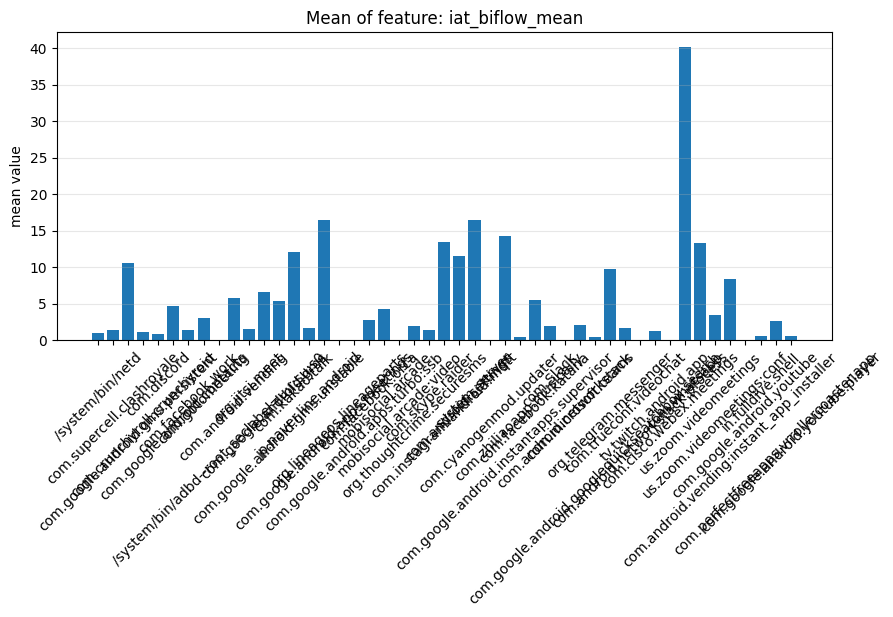

In [11]:
import matplotlib.pyplot as plt

def plot_feature_across_labels(dfs, feature_name, figsize=(10,4)):
    labels = []
    means = []

    for label, df in dfs.items():
        row = df[df["feature"] == feature_name]
        if not row.empty:
            labels.append(label)
            means.append(row["mean"].values[0])

    plt.figure(figsize=figsize)
    plt.bar(labels, means)
    plt.title(f"Mean of feature: {feature_name}")
    plt.ylabel("mean value")
    plt.xticks(rotation=45)
    plt.grid(axis="y", alpha=0.3)
    plt.show()
plot_feature_across_labels(dfs, "iat_biflow_mean")


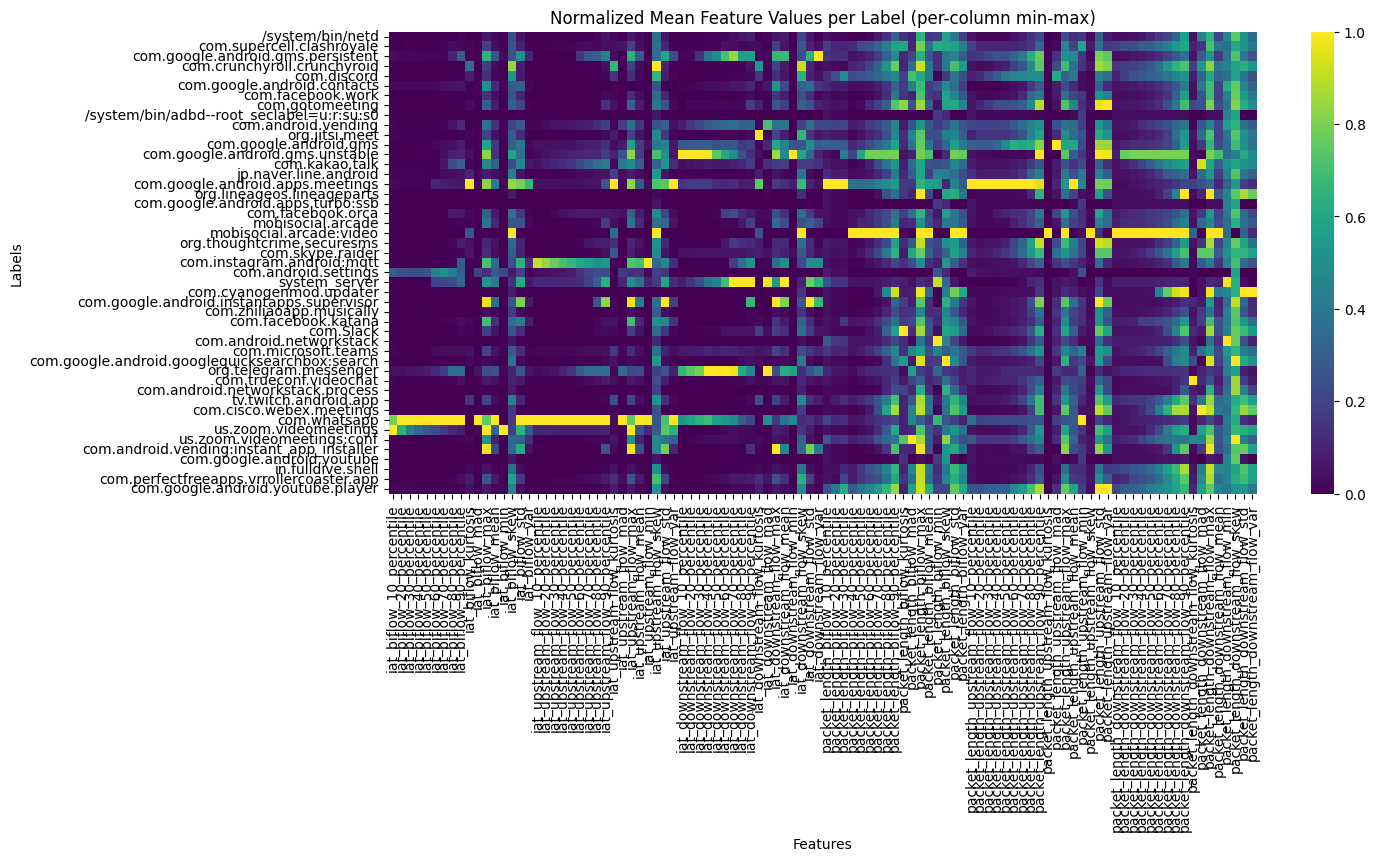

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def heatmap_feature_means_normalized(dfs):
    all_labels = list(dfs.keys())
    features = dfs[all_labels[0]]["feature"].tolist()

    # Build matrix: rows = labels, cols = features
    mean_matrix = np.vstack([dfs[label]["mean"].values for label in all_labels])

    # --- Normalize each feature column independently ---
    col_min = np.nanmin(mean_matrix, axis=0)
    col_max = np.nanmax(mean_matrix, axis=0)
    denom = (col_max - col_min)
    denom[denom == 0] = 1e-8  # avoid divide-by-zero

    norm_matrix = (mean_matrix - col_min) / denom

    # --- Plot ---
    plt.figure(figsize=(14, 6))
    sns.heatmap(norm_matrix,
                xticklabels=features,
                yticklabels=all_labels,
                cmap="viridis",
                robust=True)

    plt.title("Normalized Mean Feature Values per Label (per-column min-max)")
    plt.xlabel("Features")
    plt.ylabel("Labels")
    plt.show()

heatmap_feature_means_normalized(dfs)

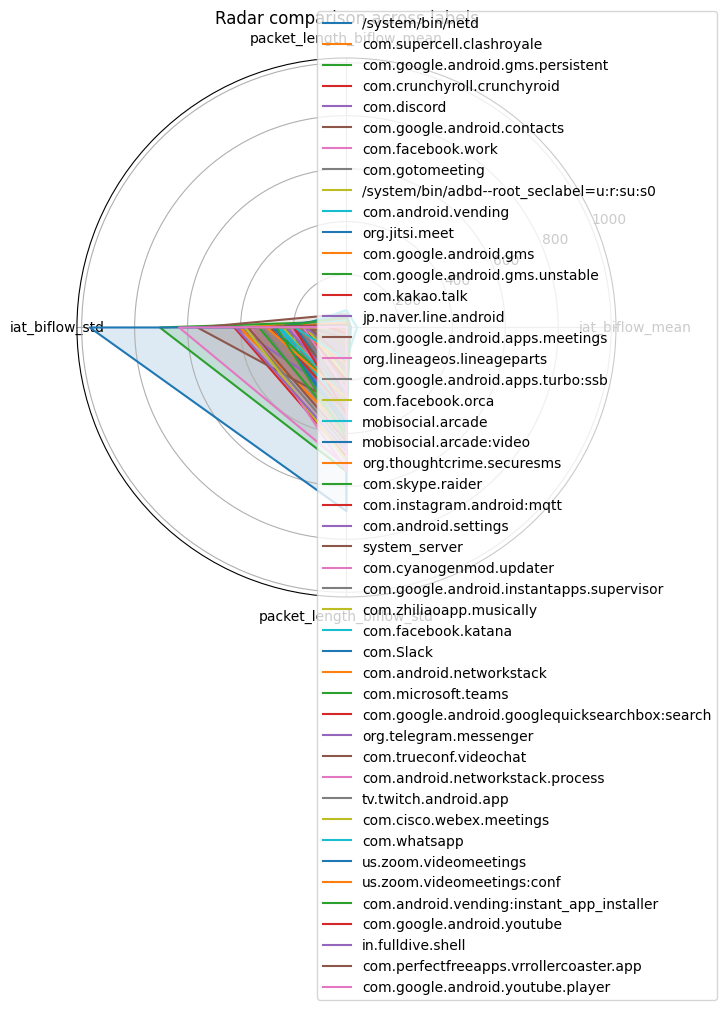

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def radar_plot_labels(dfs, feature_list):
    """
    feature_list = subset of feature names for readability
    """
    labels = list(dfs.keys())
    n_features = len(feature_list)

    # angles for radar
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # loop back to start

    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)

    for label in labels:
        df = dfs[label]
        row = df[df["feature"].isin(feature_list)]
        vals = row["mean"].values
        vals = np.concatenate([vals, vals[:1]])  # close polygon
        ax.plot(angles, vals, label=label)
        ax.fill(angles, vals, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_list, fontsize=10)
    plt.title("Radar comparison across labels")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()
radar_plot_labels(dfs, [
    "iat_biflow_mean",
    "packet_length_biflow_mean",
    "iat_biflow_std",
    "packet_length_biflow_std",
])